In [52]:
import requests
import re
import time
import datetime
import json
from tqdm import tqdm
import numpy as np
import seaborn as sns
import pandas as pd
import parser
import random
from collections import Counter
from bs4 import BeautifulSoup
from sklearn import preprocessing
import urllib
import matplotlib.pyplot as plt
import imp
imp.reload(parser)
%matplotlib inline

In [271]:
team_searched = 'PSG Paris'
team = {}
team_searched = urllib.parse.quote(team_searched.encode('utf-8'))
search_link = "http://us.soccerway.com/search/teams/?q={}".format(team_searched)
response = requests.get(search_link)
bs = BeautifulSoup(response.text, 'lxml')
results = bs.find("ul", class_='search-results')
# Take the first results
link = "http://us.soccerway.com" + results.find_all('a')[0]['href']
team['id_'] = results.find_all('a')[0]["href"].split('/')[4]
team['name'] = results.find_all('a')[0].text

## Games

### Parsing

In [58]:
nb_pages = 12
games = []
for page_number in range(nb_pages):
    link_base = 'http://us.soccerway.com/a/block_team_matches?block_id=page_team_1_block_team_matches_3&callback_params=' 
    link_ = urllib.parse.quote('{"page":0,"bookmaker_urls":[],"block_service_id":"team_matches_block_teammatches","team_id":%s,\
    "competition_id":0,"filter":"all","new_design":false}' % team['id_']) + '&action=changePage&params=' + urllib.parse.quote('{"page":-%s}' % (page_number))
    link = link_base + link_
    response = requests.get(link)

    test = json.loads(response.text)['commands'][0]['parameters']['content']
    bs = BeautifulSoup(test, 'lxml')

    for kind in ['even', 'odd']:
        for elem in bs.find_all('tr', class_ = kind):
            game = {}
            game["date"] = elem.find('td', {'class': ["full-date"]}).text
            game["competition"] = elem.find('td', {'class': ["competition"]}).text
            game["team_a"] = elem.find('td', class_='team-a').text
            game["team_b"] = elem.find('td', class_='team-b').text
            game['link'] = "http://us.soccerway.com" + elem.find('td', class_='score-time').find('a')['href']
            game["score"] = elem.find('td', class_='score-time').text.replace(' ','')
            if 'E' in game["score"]:
                game["score"] = game['score'].replace('E','')
                game['extra_time'] = True
            if 'P' in game["score"]:
                game["score"] = game['score'].replace('P','')
                game['penalties'] = True
            if datetime.datetime.strptime(game["date"], '%d/%m/%y') < datetime.datetime.now():
                game = parser.get_score_details(game, team)
                time.sleep(random.uniform(0, 0.25))
                game.update(parser.get_goals(game['link']))
            else:
                del game['score']
            games.append(game)
    games = sorted(games, key=lambda x:datetime.datetime.strptime(x['date'], '%d/%m/%y'))

### Analysis

In [75]:
df = pd.DataFrame(games)
df.date = pd.to_datetime(df.date.apply(lambda x:'/'.join([x.split('/')[1],x.split('/')[0], x.split('/')[2]])))
df['month'] = df.date.apply(lambda x:x.month)
df['year'] = df.date.apply(lambda x:x.year)
df = df.sort_values('date', ascending=False)
# le = preprocessing.LabelEncoder()
# df.competition = le.fit_transform(df.competition)
df = df[df.date < datetime.datetime.now()]
df['opponent'] = df.apply(lambda x:(x['team_a']+x['team_b']).replace('PSG', ''), axis=1)
df[['competition', 'date', 'result', 'team_a', 'score', 'team_b', 'players_teams_a', 'players_team_b']].head()
cols = ['Corners', 'Fouls', 'Offsides', 'Shots on target', 'Shots wide']
df = df.apply(lambda x:parser.shot_team(x, cols),axis=1)
df = df.drop(cols, axis=1)
df.head(3)

,competition,corners_PSG,corners_adv,date,extra_time,fouls_PSG,fouls_adv,goals_a,goals_b,link,...,score,shots_on_target_PSG,shots_on_target_adv,shots_wide_PSG,shots_wide_adv,subs_in_a,subs_in_b,team_a,team_b,year
592,LI1,8.0,2.0,2017-04-30,NaN,15.0,11.0,"[{'assist': 'Ricardo Pereira', 'time': '26', '...","[{'assist': 'Thiago Silva', 'time': '64', 'pla...",http://us.soccerway.com/matches/2017/04/30/fra...,...,3-1,5.0,1.0,9.0,3.0,"[A. Donis, M. Le Bihan, M. Obbadi]","[T. Meunier, A. Rabiot, Lucas Moura]",Nice,PSG,2017
591,CDF,13.0,1.0,2017-04-26,NaN,6.0,10.0,"[{'assist': 'E. Cavani', 'time': '26', 'player...",[],http://us.soccerway.com/matches/2017/04/26/fra...,...,5-0,8.0,3.0,8.0,1.0,"[Lucas Moura, A. Rabiot, Gonçalo Guedes]","[A. Bongiovanni, K. Dabila]",PSG,Monaco,2017
590,LI1,6.0,6.0,2017-04-22,NaN,9.0,5.0,"[{'assist': 'B. Matuidi', 'time': '29', 'playe...",[],http://us.soccerway.com/matches/2017/04/22/fra...,...,2-0,7.0,4.0,5.0,7.0,"[J. Draxler, Lucas Moura, G. Lo Celso]","[J. Ikoné, K. Dolly, S. Camara]",PSG,Montpellier,2017


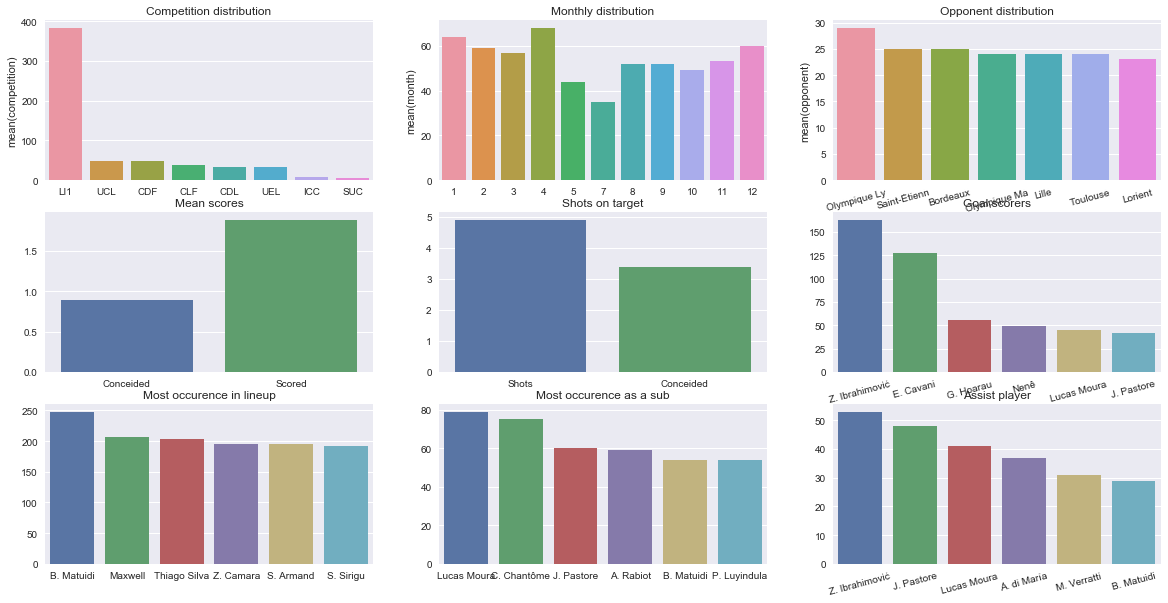

In [79]:
f, ax = plt.subplots(ncols=3, nrows=3, figsize=(20,10))

d = df.competition.value_counts()
sns.barplot(d.index, d, ax=ax[0][0])
ax[0][0].set_title('Competition distribution')

d = {'Scored':df.nb_goals_PSG.mean(), 'Conceided':df.nb_goals_adv.mean()}
sns.barplot(list(d.keys()), list(d.values()) , ax=ax[1][0])
ax[1][0].set_title('Mean scores')

d = sorted(Counter(np.concatenate(list(df.players_teams_a) + list(df.players_team_b))).items(), key=lambda x:x[1], reverse=True)[:6]
sns.barplot([elem[0] for elem in d], [elem[1] for elem in d], ax=ax[2][0])
ax[2][0].set_title('Most occurence in lineup')

d = df.month.value_counts()
sns.barplot(d.index, d, ax=ax[0][1])
ax[0][1].set_title('Monthly distribution')

d = {'Shots':df.shots_on_target_PSG.mean(), 'Conceided':df.shots_on_target_adv.mean()}
sns.barplot(list(d.keys()), list(d.values()) ,ax=ax[1][1])
ax[1][1].set_title('Shots on target')

d = sorted(Counter(np.concatenate(list(df.subs_in_a) + list(df.subs_in_b))).items(), key=lambda x:x[1], reverse=True)[:6]
sns.barplot([elem[0] for elem in d], [elem[1] for elem in d], ax=ax[2][1])
ax[2][1].set_title('Most occurence as a sub')

d = df['opponent'].value_counts()[:7]
plot = sns.barplot(d.index, d, ax=ax[0][2])
_ = plot.set_xticklabels([elem[:12] for elem in d.index], rotation=15)
ax[0][2].set_title('Opponent distribution')

d = sorted(Counter([elem['player'] for elem in np.concatenate([elem for elem in list(df.goals_a) + list(df.goals_b) if type(elem) == list ])]).items(),
            key=lambda x:x[1], reverse=True)[:6]
plot = sns.barplot([elem[0] for elem in d], [elem[1] for elem in d], ax=ax[1][2])
_ = plot.set_xticklabels([elem[0] for elem in d], rotation=15)
ax[1][2].set_title('Goal scorers')

d = sorted(Counter([elem['assist'] for elem in np.concatenate([elem for elem in list(df.goals_a) + list(df.goals_b) if type(elem) == list ]) if 'assist' in elem]).items(), 
           key=lambda x:x[1], reverse=True)[:6]
plot = sns.barplot([elem[0] for elem in d], [elem[1] for elem in d], ax=ax[2][2])
_ = plot.set_xticklabels([elem[0] for elem in d], rotation=15)
ax[2][2].set_title('Assist player')

In [150]:
## Choose competition
league = 'LI1'

df2 = df[df.competition == league]
p = df2.groupby('opponent')[['nb_goals_adv', 'nb_goals_PSG', 'shots_on_target_PSG', 'shots_on_target_adv', 'fouls_PSG', 'fouls_adv']]#.mean().sort_values('nb_goals_PSG', ascending=False)
g_nb = df2.groupby('opponent')[['year']].aggregate(len).rename(columns={'year':'nb_matches'})
g_all = df2.groupby('opponent')[['nb_goals_adv', 'nb_goals_PSG', 'shots_on_target_PSG', 'shots_on_target_adv', 'fouls_PSG', 'fouls_adv']].mean()
opponents = pd.concat([g_nb, g_all], axis=1).sort_values('nb_matches', ascending=False)

map_vic = {}
for team in opponents.index:
    map_vic[team] = df2[df2.opponent == team].result.value_counts().to_dict()
    
opponents = opponents.reset_index()
opponents = pd.concat([opponents, opponents.opponent.map(map_vic).apply(pd.Series).fillna(0)], axis=1)
opponents['%win'] = (opponents['WIN'] / opponents['nb_matches']).apply(lambda x:round(100*x,1))
opponents.head(10)

,opponent,nb_matches,nb_goals_adv,nb_goals_PSG,shots_on_target_PSG,shots_on_target_adv,fouls_PSG,fouls_adv,LOST,TIE,WIN,%win
0,Lorient,21,1.000000,1.761905,4.857143,3.357143,11.571429,10.214286,4.0,4.0,13.0,61.9
1,Toulouse,21,0.904762,1.857143,5.142857,2.571429,11.785714,14.214286,5.0,3.0,13.0,61.9
2,Olympique Lyonnais,21,1.190476,1.666667,4.642857,3.357143,12.142857,15.214286,5.0,7.0,9.0,42.9
3,Nice,21,1.000000,1.523810,5.428571,3.285714,13.071429,11.214286,8.0,3.0,10.0,47.6
4,Lille,20,0.750000,1.400000,3.714286,3.571429,15.714286,14.214286,2.0,9.0,9.0,45.0
5,Bordeaux,20,1.100000,1.250000,4.000000,3.000000,12.428571,12.642857,7.0,5.0,8.0,40.0
6,Rennes,20,0.850000,1.250000,4.785714,3.000000,12.857143,11.857143,8.0,4.0,8.0,40.0
7,Olympique Mars…,20,1.350000,1.700000,3.928571,3.642857,14.428571,12.285714,6.0,3.0,11.0,55.0
8,Saint-Étienne,19,0.684211,1.789474,4.769231,4.384615,10.230769,13.923077,2.0,6.0,11.0,57.9
9,Montpellier,16,0.937500,1.375000,4.857143,3.000000,14.214286,14.714286,2.0,8.0,6.0,37.5


## Team

In [322]:
seasons = {
    "2016/2017" : "12611",
    "2015/2016" : "11645",
    "2014/2015" : "9771",
    "2013/2014" : "8463",
    "2012/2013" : "7242",
    "2011/2012" : "5962",
    "2010/2011" : "5085",
    "2009/2010" : "3455"
}

In [323]:
team['squad'] = {}
for k,v in seasons.items():
    link_base = 'http://us.soccerway.com/a/block_team_squad?block_id=page_team_1_block_team_squad_3&callback_params='
    link_ = urllib.parse.quote('{"team_id":%s}' % team['id_']) + '&action=changeSquadSeason&params=' + urllib.parse.quote('{"season_id":%s}' % v)
    link = link_base + link_
    
    response = requests.get(link)
    test = json.loads(response.text)['commands'][0]['parameters']['content']
    bs = BeautifulSoup(test, 'lxml')
    
    players = bs.find('tbody').find_all('tr')
    squad = [{
        k: convert_int(player.find('td', class_=k).text)
          for k in [k for k,v in Counter(np.concatenate([elem.attrs['class'] for elem in player.find_all('td')])).items() 
                    if v < 2 and k not in ['photo', '', 'flag']]
     } for player in players]
    team['squad'][k] = squad
    try:
        coach = {'position': 'Coach', 'name':bs.find_all('tbody')[1].text}
        team['coach'][k] = coach
    except: pass

In [324]:
def convert_int(string):
    try:
        string = int(string)
        return string
    except:
        return string

In [379]:
d = pd.DataFrame(list(np.concatenate(list(team['squad'].values()))))
cols = [elem for elem in d if elem not in ['age', 'position', 'shirtnumber']]
stats_all_time = d.groupby('name')[cols].sum()
stats_all_time['goals/games'] = stats_all_time['goals'] / stats_all_time['appearances']
stats_all_time = stats_all_time.reset_index()
stats_all_time['position'] = stats_all_time['name'].map(d[['position', 'name']].set_index('name').to_dict()['position'])
stats_all_time['assists/games'] = stats_all_time['assists'] / stats_all_time['appearances']
stats_all_time['yellow-cards/games'] = stats_all_time['yellow-cards'] / stats_all_time['appearances']
stats_all_time['decives_actions/games'] = (stats_all_time['assists'] + stats_all_time['goals'])/ stats_all_time['appearances']
stats_all_time['min/games'] = stats_all_time['game-minutes'] / stats_all_time['appearances']
stats_all_time = stats_all_time.set_index("name", drop=True)
stats_all_time.sort_values('appearances', ascending=False).head(10)

,2nd-yellow-cards,appearances,assists,game-minutes,goals,lineups,red-cards,subs-in,subs-on-bench,subs-out,yellow-cards,goals/games,position,assists/games,yellow-cards/games,decives_actions/games,min/games
name,,,,,,,,,,,,,,,,,
B. Matuidi,1,198,15,14326,23,159,0,39,48,40,25,0.116162,M,0.075758,0.126263,0.191919,72.353535
J. Pastore,0,160,40,11168,25,129,0,31,41,55,13,0.156250,M,0.250000,0.081250,0.406250,69.800000
T. Motta,0,146,7,11260,7,131,3,15,21,36,39,0.047945,M,0.047945,0.267123,0.095890,77.123288
Lucas Moura,0,145,28,9099,30,101,0,44,51,67,8,0.206897,M,0.193103,0.055172,0.400000,62.751724
S. Sirigu,0,145,0,12904,0,144,1,1,34,2,4,0.000000,G,0.000000,0.027586,0.000000,88.993103
C. Jallet,1,143,15,10785,7,118,1,25,32,13,10,0.048951,D,0.104895,0.069930,0.153846,75.419580
Maxwell,0,142,16,11977,12,133,0,9,57,10,5,0.084507,D,0.112676,0.035211,0.197183,84.345070
M. Verratti,1,132,23,9279,4,108,0,24,33,50,41,0.030303,M,0.174242,0.310606,0.204545,70.295455
Thiago Silva,0,131,3,11467,8,130,1,1,5,5,8,0.061069,D,0.022901,0.061069,0.083969,87.534351


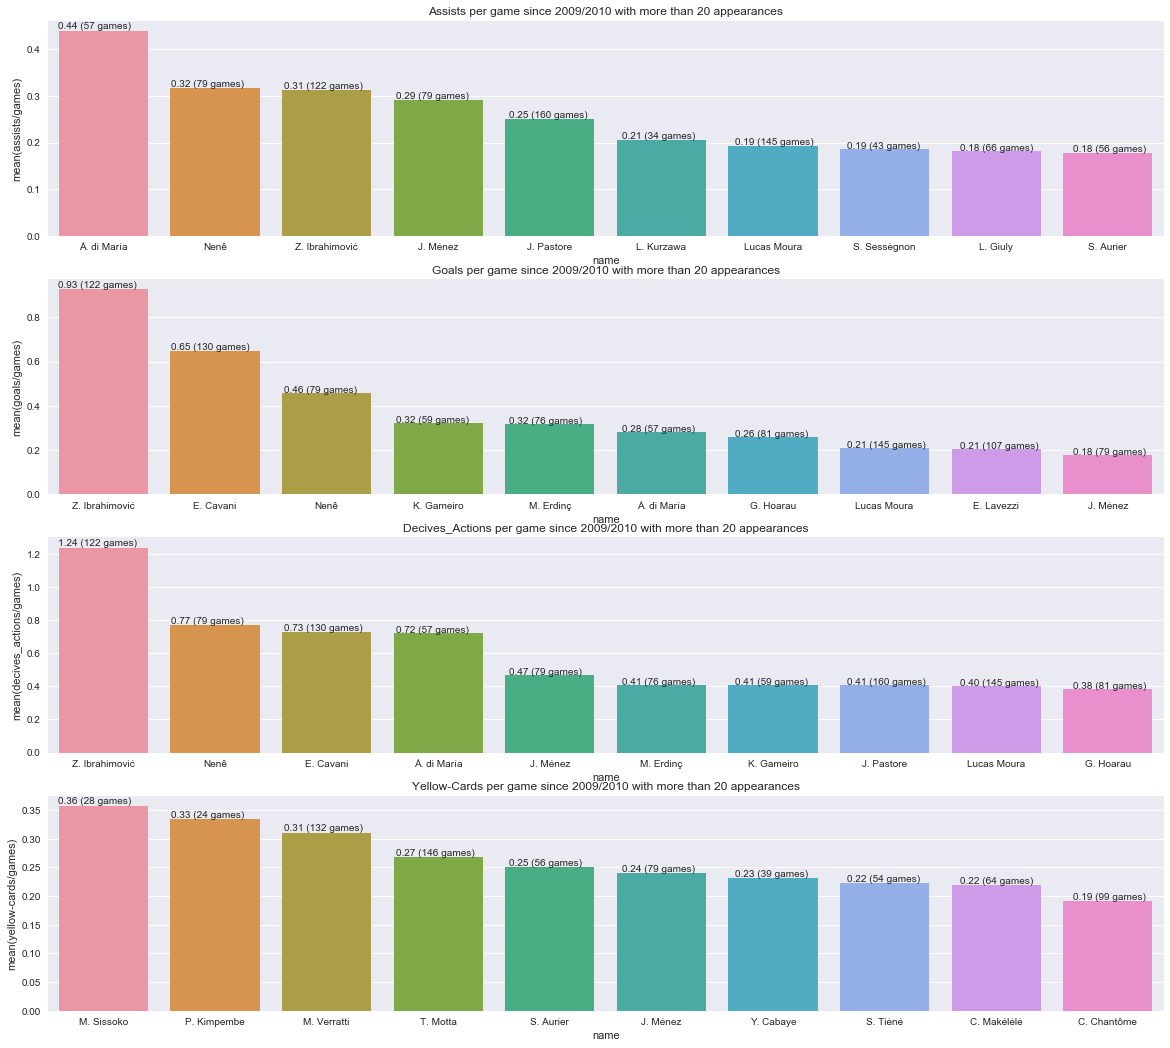

In [384]:
f, ax = plt.subplots(nrows=4, figsize=(20,10))
plt.subplots_adjust(top=1.5)


for i, kind in enumerate(['assists', 'goals', 'decives_actions', 'yellow-cards']):
    nb_appar = 20
    d1 = stats_all_time[stats_all_time.appearances > nb_appar].sort_values('{}/games'.format(kind), ascending=False)
    d = d1['{}/games'.format(kind)][:10]
    sns.barplot(d.index, d, ax=ax[i])
    ax[i].set_title('{} per game since 2009/2010 with more than {} appearances'.format(kind.title(), nb_appar))
    for k, p in enumerate(ax[i].patches):
        ax[i].annotate('%.2f (%d games)' % (p.get_height(), d1.appearances[k]), (p.get_x() * 1.01, p.get_height() * 1.01))

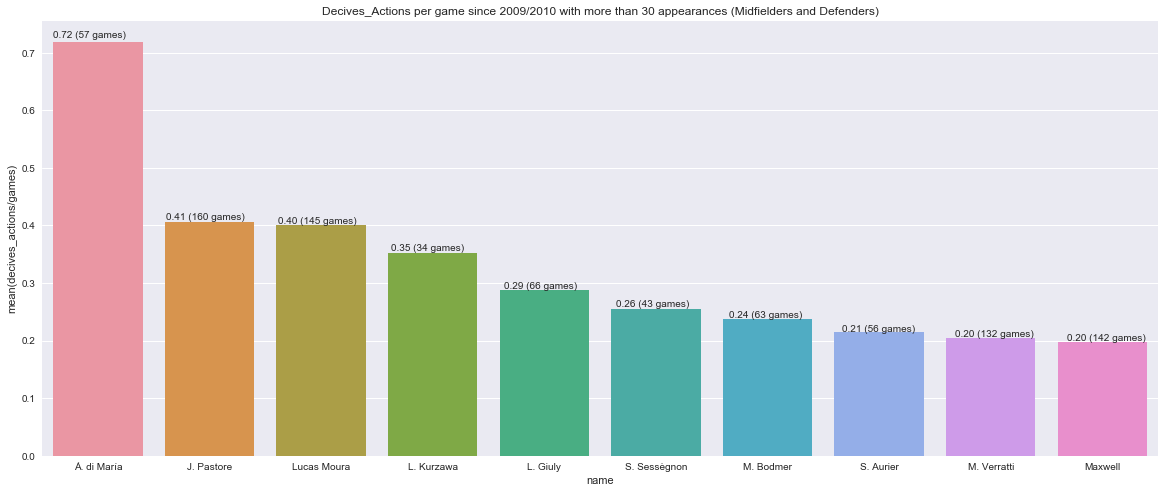

In [409]:
f, ax = plt.subplots(figsize=(20,8))
kind = 'decives_actions'
nb_appar = 30
d1 = stats_all_time[(stats_all_time.appearances > nb_appar) & (stats_all_time.position.isin(['D', 'M']))].sort_values('{}/games'.format(kind), ascending=False)
d = d1['{}/games'.format(kind)][:10]
sns.barplot(d.index, d, ax = ax)
ax.set_title('{} per game since 2009/2010 with more than {} appearances (Midfielders and Defenders)'.format(kind.title(), nb_appar))
for k, p in enumerate(ax.patches):
    ax.annotate('%.2f (%d games)' % (p.get_height(), d1.appearances[k]), (p.get_x() * 1.01, p.get_height() * 1.01))